In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os
import numpy as np
from tensorflow.keras.models import load_model


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# set up data path, define alphabet
data_path = "/Users/reagan/desktop/AI/project_work2/"
alphabet = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", 
            "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X",  "Y", "Z"]

In [ ]:

# set up camera
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 450)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 450)

index = 0

# loop through alphabet
while index < len(alphabet):
    letter = alphabet[index]
    letter_path = os.path.join(data_path, letter)
    os.makedirs(letter_path, exist_ok=True)
    
    print(letter, letter_path)
    
    # set up count for images
    count = 0

    # main loop for collecting images
    while True:
        ret, frame = cap.read()   
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # convert to RGB for mediapipe
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks is not None:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(0, 117, 128), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(53, 101, 77), thickness=2, circle_radius=2)
                                          )
                
                # Extract landmark positions and save them to a file
                landmarks_positions = [(int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])) for lm in hand_landmarks.landmark] # integer values of landmark positions 
                landmarks_file_path = os.path.join(letter_path, letter + str(count) + '.npy')
                np.save(landmarks_file_path, landmarks_positions)

                # Extract bounding box of hand
                x_values = [lm[0] for lm in landmarks_positions] # list of x values of landmarks
                y_values = [lm[1] for lm in landmarks_positions] # list of y values of landmarks 

                min_x, min_y, max_x, max_y = min(x_values), min(y_values), max(x_values), max(y_values)

                bounding_box = (min_x, min_y, max_x - min_x, max_y - min_y)
                
                # Add a scaling factor to make the bounding rectangle larger
                scaling_factor = 1.5
                bounding_box = (
                    int(bounding_box[0] - (bounding_box[2] * (scaling_factor - 1) / 2)),  # adjusted left coordinate
                    int(bounding_box[1] - (bounding_box[3] * (scaling_factor - 1) / 2)),  # adjusted right coordinate
                    int(bounding_box[2] * scaling_factor),  # adjusted width
                    int(bounding_box[3] * scaling_factor)  # adjusted height
                )

                # Draws lines between hand landmarks 
                for connection in mp_hands.HAND_CONNECTIONS:
                    start_point = tuple(np.multiply([hand_landmarks.landmark[connection[0]].x, hand_landmarks.landmark[connection[0]].y], [450, 450]).astype(int))
                    end_point = tuple(np.multiply([hand_landmarks.landmark[connection[1]].x, hand_landmarks.landmark[connection[1]].y], [450, 450]).astype(int))
                    cv2.line(rgb_frame, start_point, end_point, (255, 0, 0), 2)
                
                # Draw rectangle around hand using adjusted bounding box
                cv2.rectangle(frame, (int(bounding_box[0]), int(bounding_box[1])),
                              (int(bounding_box[0] + bounding_box[2]), int(bounding_box[1] + bounding_box[3])), (0, 0, 0), 2)

                # Extract hand crop
                hand_crop = frame[int(bounding_box[1]):int(bounding_box[1] + bounding_box[3]),
                                  int(bounding_box[0]):int(bounding_box[0] + bounding_box[2])]
                if hand_crop.size != 0:
                    if cv2.waitKey(1) & 0xFF == ord('c'):
                        image_name  = letter + str(count) + '.png'
                        image_path = os.path.join(letter_path, image_name)
                        cv2.imwrite(image_path, hand_crop)
                        print('image_name', image_name)
                        count += 1

                
                print('hand')

        else:
            print('no hand')

        cv2.imshow('frame', frame)

        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        elif key == ord(' '):
            count = 0
            break

    index += 1

print(count)

cap.release()
cv2.destroyAllWindows()


In [ ]:

# lists for storing data
landmarks_list = []
labels = []

# initialize LabelEncoder
label_encoder = LabelEncoder() 

# loop through each letter in alphabet and each file in each letter folder
for letter in alphabet:  
    letter_path = os.path.join(data_path, letter) 
    for file_name in os.listdir(letter_path):
        landmarks_path = os.path.join(letter_path, file_name.replace(".png", ".npy")) # replace image extension with .npy extension
        print(landmarks_path)

        # load landmarks
        hand_landmarks = np.load(landmarks_path) # load landmarks

        landmarks_list.append(hand_landmarks.flatten())
        labels.append(letter)

# encode labels
labels = label_encoder.fit_transform(labels)

landmarks = np.array(landmarks_list)
labels = np.array(labels)

# convert labels to one-hot encoding
labels_one_hot = to_categorical(labels, num_classes=len(alphabet))

# split data using stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 splits, shuffle data, set random state for reproducibility

for train_index, test_index in skf.split(landmarks, labels):
    landmarks_train, landmarks_test = landmarks[train_index], landmarks[test_index]
    y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]

    print(landmarks_train.shape)
    print(landmarks_test.shape)
    print(y_train.shape)
    print(y_test.shape)


In [49]:

model = models.Sequential()
#flatten the input
model.add(layers.Flatten(input_shape=(42,)))  # 42 = 21 landmarks * 2 coordinates
model.add(layers.Dense(128, activation='relu')) # 128 = 2^7 nuerons in hidden layer
model.add(layers.Dropout(0.5)) #  50% dropout rate to prevent overfitting
model.add(layers.Dense(len(alphabet), activation='softmax'))# 26 neurons in output layer for 26 classes


#comile the model
#adam optimizer is used to minimize the loss function by updating the weights for each epoch
#loss function is categorical crossentropy because there are more than 2 classes
#accuracy is used to measure the performance of the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # 26 classes so categorical crossentropy

#train the model
history = model.fit( 
    x=landmarks_train,     #input data
    y=y_train,            #output data (labels)
    epochs=64,            #32 iterations
    batch_size= 128,        #number of samples per gradient update
    validation_data=(landmarks_test, y_test) #data to validate the model on
)


test_loss, test_acc = model.evaluate(landmarks_test, y_test)
print(f"Test accuracy: {test_acc}")


model.save("/Users/reagan/desktop/AI/AI_ASL/model.h30")


Epoch 1/64
403/403 [==============================] - 4s 5ms/step - loss: 17.1389 - accuracy: 0.3041 - val_loss: 1.3812 - val_accuracy: 0.6961
Epoch 2/64
403/403 [==============================] - 2s 4ms/step - loss: 1.7771 - accuracy: 0.4624 - val_loss: 0.8276 - val_accuracy: 0.8012
Epoch 3/64
403/403 [==============================] - 2s 4ms/step - loss: 1.4201 - accuracy: 0.5574 - val_loss: 0.5299 - val_accuracy: 0.8580
Epoch 4/64
403/403 [==============================] - 2s 4ms/step - loss: 1.1286 - accuracy: 0.6342 - val_loss: 0.3222 - val_accuracy: 0.9530
Epoch 5/64
403/403 [==============================] - 2s 4ms/step - loss: 0.9434 - accuracy: 0.6885 - val_loss: 0.2652 - val_accuracy: 0.9515
Epoch 6/64
403/403 [==============================] - 2s 4ms/step - loss: 0.8304 - accuracy: 0.7233 - val_loss: 0.1777 - val_accuracy: 0.9739
Epoch 7/64
403/403 [==============================] - 2s 4ms/step - loss: 0.7584 - accuracy: 0.7441 - val_loss: 0.1355 - val_accuracy: 0.9770
Epoch

INFO:tensorflow:Assets written to: /Users/reagan/desktop/AI/AI_ASL/model.h30/assets


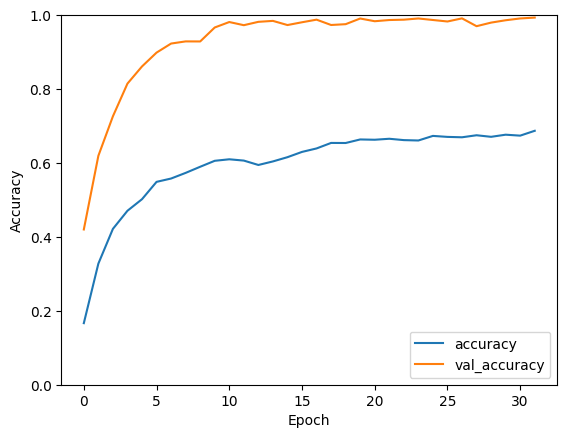

In [42]:

#plot the accuracy and loss for the training and validation data

plt.plot(history.history['accuracy'], label='accuracy') 
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

403/403 [==============================] - 1s 1ms/step


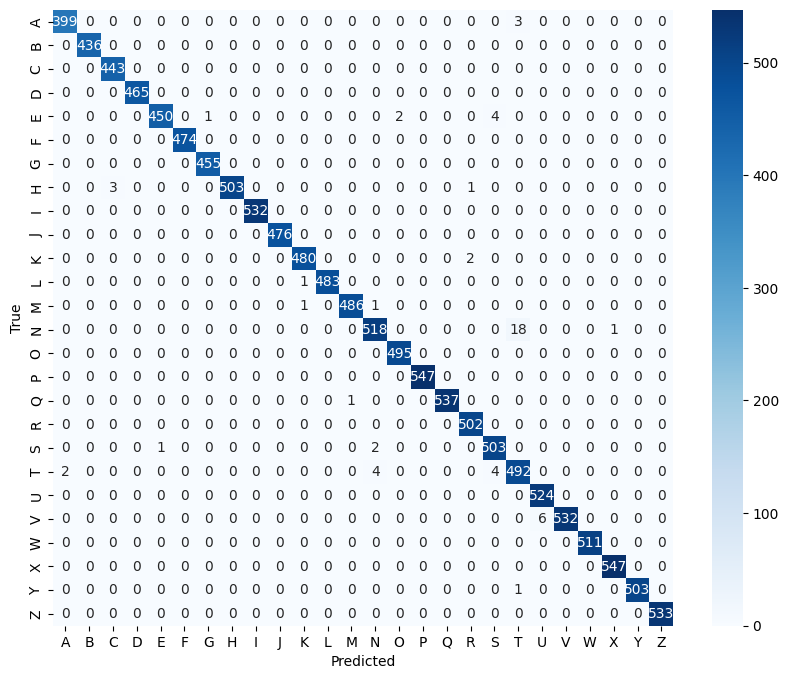

[ 0  0  0 ... 25 25 25]


In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred = model.predict(landmarks_test)

# Convert one-hot encoded labels back to integer labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(y_pred_labels)


In [ ]:

model = load_model("/Users/reagan/desktop/AI/model.h30")  # Load the model

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 450)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 450)

MAX_LINE_LEN = 10  # max number of characters per line
sentence = "" 
word = ""


while True:
    ret, frame = cap.read()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    cv2.putText(frame, f"Word: {word}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    lines = []
    if sentence.split():
        words = sentence.split()
        line = words[0]
        for word in words[1:]:
            if len(line + ' ' + word) <= MAX_LINE_LEN:
                line += ' ' + word
            else:
                lines.append(line)
                line = word
        lines.append(line)
        y_offset = 0
        for line in lines:
            cv2.putText(frame, f"Sentence: {line}", (10, 90 + y_offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255)) # display sentence
            y_offset += 30
    else:
        cv2.putText(frame, f"Sentence: {sentence}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))


    if results.multi_hand_landmarks is not None:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(0, 117, 128), thickness=2, circle_radius=4),
                                      mp_drawing.DrawingSpec(color=(53, 101, 77), thickness=2, circle_radius=2)
                                      )

            landmarks_positions = [(int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0]))
                                   for lm in hand_landmarks.landmark]
            landmarks_array = np.array(landmarks_positions).flatten()

            x_values = [lm[0] for lm in landmarks_positions]
            y_values = [lm[1] for lm in landmarks_positions]

            min_x, min_y, max_x, max_y = min(x_values), min(y_values), max(x_values), max(y_values)

            scaling_factor = 1.5
            bounding_box = (
                int(min_x - (max_x - min_x) * (scaling_factor - 1) / 2),
                int(min_y - (max_y - min_y) * (scaling_factor - 1) / 2),
                int((max_x - min_x) * scaling_factor),
                int((max_y - min_y) * scaling_factor)
            )

            for connection in mp_hands.HAND_CONNECTIONS:
                start_point = tuple(np.multiply([hand_landmarks.landmark[connection[0]].x,
                                                 hand_landmarks.landmark[connection[0]].y], [450, 450]).astype(int))
                end_point = tuple(np.multiply([hand_landmarks.landmark[connection[1]].x,
                                               hand_landmarks.landmark[connection[1]].y], [450, 450]).astype(int))
                cv2.line(rgb_frame, start_point, end_point, (255, 0, 0), 2)

            cv2.rectangle(frame, (int(bounding_box[0]), int(bounding_box[1])),
                          (int(bounding_box[0] + bounding_box[2]), int(bounding_box[1] + bounding_box[3])), (0, 0, 0), 2)

            hand_crop = frame[int(bounding_box[1]):int(bounding_box[1] + bounding_box[3]),
                              int(bounding_box[0]):int(bounding_box[0] + bounding_box[2])]

            landmarks_input = landmarks_array.reshape(1, -1)
            predictions = model.predict(landmarks_input)
            predicted_class = np.argmax(predictions)

            confidence = predictions[0, predicted_class]

            if confidence > 0.5:
                cv2.putText(frame, f"Predicted: {alphabet[np.argmax(predictions)]} ({confidence:.2f})", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('frame', frame)

    key = cv2.waitKey(1)

    if key == ord('q'):
        break
    elif key == ord('c'):
        sentence += alphabet[predicted_class]
        word += alphabet[predicted_class]
    elif key == ord('d'):
        sentence = sentence[:len(sentence) - 1]
        word = word[:len(word)-1]
    elif key == ord('s'):
        sentence += ''
        word = ""

cap.release()
cv2.destroyAllWindows()
